In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pyro
import pyro.contrib.examples.polyphonic_data_loader as poly
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions import TransformedDistribution
from pyro.distributions.transforms import affine_autoregressive
from pyro.infer import SVI, JitTrace_ELBO, Trace_ELBO, TraceEnum_ELBO, TraceTMC_ELBO, config_enumerate
from pyro.optim import ClippedAdam
import ot
import torch.nn.functional as F
import mido
import musics

In [5]:
class Emitter(nn.Module):
    def __init__(self, input_dim, z_dim, emission_dim, use_cuda=False):
        super().__init__()
        self.input_dim = input_dim
        self.use_cuda = use_cuda
        self.lin_z_to_hidden = nn.Linear(z_dim, emission_dim)
        self.lin_hidden_to_hidden = nn.Linear(emission_dim, emission_dim)
        self.lin_hidden_to_input = nn.Linear(emission_dim, input_dim)
        self.relu = nn.ReLU()

    def forward(self, z_t):
        h1 = self.relu(self.lin_z_to_hidden(z_t))
        h2 = self.relu(self.lin_hidden_to_hidden(h1))
        if self.input_dim == 1:
            x = self.lin_hidden_to_input(h2)
        else:
            ps = torch.sigmoid(self.lin_hidden_to_input(h2))
            if self.use_cuda: 
                eps = torch.rand(self.input_dim).cuda()
            else : eps = torch.rand(self.input_dim)
            appxm = torch.log(eps + 1e-20) - torch.log(1-eps + 1e-20) + torch.log(ps + 1e-20) - torch.log(1-ps + 1e-20)
            x = torch.sigmoid(appxm)
        return x

class GatedTransition(nn.Module):

    def __init__(self, z_dim, transition_dim):
        super().__init__()
        # initialize the six linear transformations used in the neural network
        self.lin_gate_z_to_hidden = nn.Linear(z_dim, transition_dim)
        self.lin_gate_hidden_to_z = nn.Linear(transition_dim, z_dim)
        self.lin_proposed_mean_z_to_hidden = nn.Linear(z_dim, transition_dim)
        self.lin_proposed_mean_hidden_to_z = nn.Linear(transition_dim, z_dim)
        self.lin_sig = nn.Linear(z_dim, z_dim)
        self.lin_z_to_loc = nn.Linear(z_dim, z_dim)
        # modify the default initialization of lin_z_to_loc
        # so that it's starts out as the identity function
        self.lin_z_to_loc.weight.data = torch.eye(z_dim)
        self.lin_z_to_loc.bias.data = torch.zeros(z_dim)
        # initialize the three non-linearities used in the neural network
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()

    def forward(self, z_t_1):
        _gate = self.relu(self.lin_gate_z_to_hidden(z_t_1))
        gate = torch.sigmoid(self.lin_gate_hidden_to_z(_gate))
        _proposed_mean = self.relu(self.lin_proposed_mean_z_to_hidden(z_t_1))
        proposed_mean = self.lin_proposed_mean_hidden_to_z(_proposed_mean)
        loc = (1 - gate) * self.lin_z_to_loc(z_t_1) + gate * proposed_mean
        scale = self.softplus(self.lin_sig(self.relu(proposed_mean)))
        return loc, scale

class Combiner(nn.Module):
    def __init__(self, z_dim, rnn_dim):
        super().__init__()
        self.lin_z_to_hidden = nn.Linear(z_dim, rnn_dim)
        self.lin_hidden_to_loc = nn.Linear(rnn_dim, z_dim)
        self.lin_hidden_to_scale = nn.Linear(rnn_dim, z_dim)
        self.tanh = nn.Tanh()
        self.softplus = nn.Softplus()

    def forward(self, z_t_1, h_rnn):
        h_combined = 0.5 * (self.tanh(self.lin_z_to_hidden(z_t_1)) + h_rnn)
        loc = self.lin_hidden_to_loc(h_combined)
        scale = self.softplus(self.lin_hidden_to_scale(h_combined))
        return loc, scale

class Encoder(nn.Module):
    def __init__(self, input_dim=88, z_dim=100,rnn_dim=60, num_layers=1, rnn_dropout_rate=0.1,num_iafs=0, iaf_dim=50, N_z0 = 10, use_cuda=False, rnn_check=False):
        super().__init__()
        self.combiner = Combiner(z_dim, rnn_dim)
        rnn_dropout_rate = 0. if num_layers == 1 else rnn_dropout_rate
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=rnn_dim, nonlinearity='relu',
                            batch_first=True, bidirectional=False, num_layers=num_layers,
                            dropout=rnn_dropout_rate)
        self.z_0 = nn.Parameter(torch.zeros(z_dim))
        self.z_q_0 = nn.Parameter(torch.zeros(z_dim))
        self.h_0 = nn.Parameter(torch.randn(1, 1, rnn_dim))
        self.use_cuda = use_cuda
        if use_cuda:
            self.cuda()
        self.rnn_check = rnn_check

    def forward(self, mini_batch, mini_batch_reversed, mini_batch_mask, mini_batch_seq_lengths, annealing_factor=1.0):
        T_max = mini_batch.size(1)
        h_0_contig = self.h_0.expand(1, mini_batch.size(0), self.rnn.hidden_size).contiguous()
        rnn_output, _ = self.rnn(mini_batch_reversed, h_0_contig)
        rnn_output = poly.pad_and_reverse(rnn_output, mini_batch_seq_lengths)
        z_prev = self.z_q_0.expand(mini_batch.size(0), self.z_q_0.size(0))
        z_container = []
        z_loc_container = []
        z_scale_container = []
        for t in range(1,T_max+1):
            z_loc, z_scale = self.combiner(z_prev, rnn_output[:, t - 1, :])
            if self.use_cuda:
                eps = torch.randn(z_loc.size()).cuda()
            else: eps = torch.randn(z_loc.size())
            z_t = z_loc + z_scale * eps
            z_prev = z_t
            z_container.append(z_t)
            z_loc_container.append(z_loc)
            z_scale_container.append(z_scale)
        
        z_container = torch.stack(z_container)
        z_loc_container = torch.stack(z_loc_container)
        z_scale_container = torch.stack(z_scale_container)
        return z_container.transpose(0,1), z_loc_container.transpose(0,1), z_scale_container.transpose(0,1)

class Prior(nn.Module):
    def __init__(self, z_dim=100, transition_dim=200,  N_z0 = 10, use_cuda=False):
        super().__init__()
        self.trans = GatedTransition(z_dim, transition_dim)
        self.z_0 = nn.Parameter(torch.zeros(z_dim))
        self.z_q_0 = nn.Parameter(torch.zeros(z_dim))
        self.use_cuda = use_cuda

    def forward(self, length, N_generate):
        T_max = length
        z_prev = self.z_q_0.expand(N_generate, self.z_q_0.size(0))
        z_container = []
        z_loc_container = []
        z_scale_container = []
        for t in range(1,T_max+1):
            z_loc, z_scale = self.trans(z_prev)
            if self.use_cuda:
                eps = torch.randn(z_loc.size()).cuda()
            else: eps = torch.randn(z_loc.size())
            z_t = z_loc + z_scale * eps
            z_prev = z_t
            z_container.append(z_t)
            z_loc_container.append(z_loc)
            z_scale_container.append(z_scale)
        z_container = torch.stack(z_container)
        z_loc_container = torch.stack(z_loc_container)
        z_scale_container = torch.stack(z_scale_container)
        return z_container.transpose(0,1), z_loc_container.transpose(0,1), z_scale_container.transpose(0,1)

In [81]:
now = "重要20220114_14_57"
now = "20220116_11_55"
now = "20220116_12_02"
est_path = os.path.join("saveEstimate", now)
os.makedirs(est_path, exist_ok=True)

# get the name of dir of saveData
data_path = os.path.join("saveData", now)
files = os.listdir(data_path)
files_dir = [f for f in files if os.path.isdir(os.path.join(data_path, f))]

N_songs = 10
length = 4
mini_batch_size = 20
z_dim = 2 #100 #2
rnn_dim = 30 #200 #30
transition_dim = 30 #200 #30
emission_dim = 30 #100 #30

reconstructions = []
generations = []
trainings = []
for i in range(len(files_dir)):
    encoder = Encoder(input_dim=1, z_dim=z_dim, rnn_dim=rnn_dim, N_z0=N_songs)
    prior = Prior(z_dim=z_dim, transition_dim=transition_dim,  N_z0=N_songs)
    decoder = Emitter(input_dim=1, z_dim=z_dim, emission_dim=emission_dim)
    # if files_dir[i] == "Epoch2000":
    #     continue
    DMM_dics = torch.load(os.path.join(data_path, files_dir[i],"DMM_dic"))
    training_data_sequences = DMM_dics["mini_batch"]
    encoder.load_state_dict(DMM_dics["Encoder_dic"]())
    prior.load_state_dict(DMM_dics["Prior_dic"]())
    decoder.load_state_dict(DMM_dics["Emitter_dic"]())

    which_mini_batch = 0
    training_seq_lengths = torch.tensor([length]*N_songs)
    data_dim = training_data_sequences.size(-1)

    N_train_data = len(training_seq_lengths)
    N_train_time_slices = float(torch.sum(training_seq_lengths))
    N_mini_batches = int(N_train_data / mini_batch_size +
                    int(N_train_data % mini_batch_size > 0))
    shuffled_indices = torch.randperm(N_train_data)
    mini_batch_start = (which_mini_batch * mini_batch_size)
    mini_batch_end = np.min([(which_mini_batch + 1) * mini_batch_size, N_train_data])
    mini_batch_indices = shuffled_indices[mini_batch_start:mini_batch_end]

    # grab a fully prepped mini-batch using the helper function in the data loader
    mini_batch, mini_batch_reversed, mini_batch_mask, mini_batch_seq_lengths \
        = poly.get_mini_batch(mini_batch_indices, training_data_sequences,
                                training_seq_lengths)

    pri_z, pri_z_loc, pri_z_scale = prior(length = mini_batch.size(1), N_generate= 1000)
    pos_z,a,b = encoder(mini_batch, mini_batch_reversed, mini_batch_mask, mini_batch_seq_lengths)
    reconed_x = decoder(pos_z)
    reconstructions.append(reconed_x)
    generations.append(decoder(pri_z))
    trainings.append(mini_batch)
    # entropy = 0
    # entropy -= torch.sum(torch.log(multi_normal_prob(pri_z_loc, pri_z_scale, pri_z))) / args.N_generate
    # entropy += 0.5 * pri_z.size(1) * pri_z.size(2) * torch.log(torch.tensor(2*math.pi))
    # how_close = calc_how_close_to_mini_batch(decoder(pri_z), mini_batch)

    # ppath = os.path.join(est_path, files_dir[i])
    # os.makedirs(ppath, exist_ok=True)
    # os.makedirs(os.path.join(ppath,"Reconstruction"), exist_ok=True)
    # os.makedirs(os.path.join(ppath,"Generation"), exist_ok=True)
    # os.makedirs(os.path.join(ppath,"Training"), exist_ok=True)
    # for j in range(args.N_pics):
    #     saveReconSinGraph(mini_batch[j], reconed_x[j], pri_z.size(1), os.path.join(ppath,"Reconstruction"), j, args.date)
    # saveGeneSinGraph(decoder(pri_z)[:3], pri_z.size(1), os.path.join(ppath,"Generation"), j, args.date)
    # saveTrainSinGraph(mini_batch[:5], pri_z.size(1), os.path.join(ppath,"Training"), 1, args.date)
reconstructions = torch.stack(reconstructions)
generations = torch.stack(generations)
trainings = torch.stack(trainings)


In [82]:
training_av = torch.tensor([[0.0], [5.0], [10.0], [15.0]])
training_sg = torch.tensor([[1.0], [1.0], [1.0], [1.0]])

# calc av of gene
def cal_av(gene):
    N = gene.size(0)
    return gene.sum(dim=0) / N

# cal sigma of gene
def cal_sg(gene):
    N = gene.size(0)
    av = cal_av(gene)
    av = av.expand(N, gene.size(1), gene.size(2))
    return ((gene-av)*(gene-av)).sum(dim=0) / N


tensor([[-0.1522],
        [ 5.2284],
        [10.8251],
        [14.9425]], grad_fn=<DivBackward0>)
tensor([[0.8087],
        [1.0590],
        [2.2331],
        [1.6175]], grad_fn=<DivBackward0>)


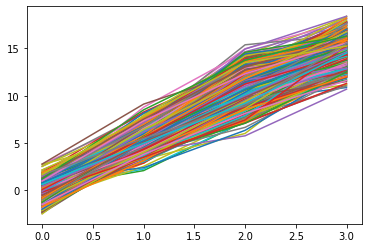

In [85]:
number = 3
av = cal_av(generations[number])
sg = cal_sg(generations[number])

print(av)
print(sg)
for dat in generations[number]:
    plt.plot(dat.detach().numpy())